In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, silhouette_score
import geopandas as gpd

# Violent Crime Rates by US State

## About the dataset

> This data set contains statistics, in arrests per 100,000
> residents for assault, murder, and rape in each of the 50 US
> states in 1973.  Also given is the percent of the population
> living in urban areas.

The dataset is installed by default with the R programming language and can be accessed with: `print(USArrests)` in R.

The help text provided for the dataset, which provides an attribution for the data is shown below for information. In R, this help message can be accessed with: `help(USArrests)`.

## Disclaimer

**Note that this analysis has been undertaken as an academic exercise in the application of PCA and clustering, based on a commonly used, but old and flawed dataset. The results presented below are not intended to be used in a political context and should not be interpreted as representative of the author's personal views.**

In [2]:
with open("data/USArrests_help.txt", "r") as help_text:
    print(help_text.read())

USArrests               package:datasets               R Documentation

Violent Crime Rates by US State

Description:

     This data set contains statistics, in arrests per 100,000
     residents for assault, murder, and rape in each of the 50 US
     states in 1973.  Also given is the percent of the population
     living in urban areas.

Usage:

     USArrests

Format:

     A data frame with 50 observations on 4 variables.

       [,1]  Murder    numeric  Murder arrests (per 100,000)
       [,2]  Assault   numeric  Assault arrests (per 100,000)
       [,3]  UrbanPop  numeric  Percent urban population
       [,4]  Rape      numeric  Rape arrests (per 100,000)

Note:

     ‘USArrests’ contains the data as in McNeil's monograph.  For the
     ‘UrbanPop’ percentages, a review of the table (No. 21) in the
     Statistical Abstracts 1975 reveals a transcription error for
     Maryland (and that McNeil used the same “round to even” rule that
     R's ‘round()’ uses), as found by Daniel S 

## Initial data inspection

In [3]:
arrests_df = pd.read_csv("data/USArrests.csv", index_col=0)
arrests_df

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6
Colorado,7.9,204,78,38.7
Connecticut,3.3,110,77,11.1
Delaware,5.9,238,72,15.8
Florida,15.4,335,80,31.9
Georgia,17.4,211,60,25.8


In [4]:
arrests_df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


We can see straight away that the data will need to be scaled to facilitate the use of PCA. The number of Assault arrests per 100,000 residents would otherwise dominate the outputs of PCA.

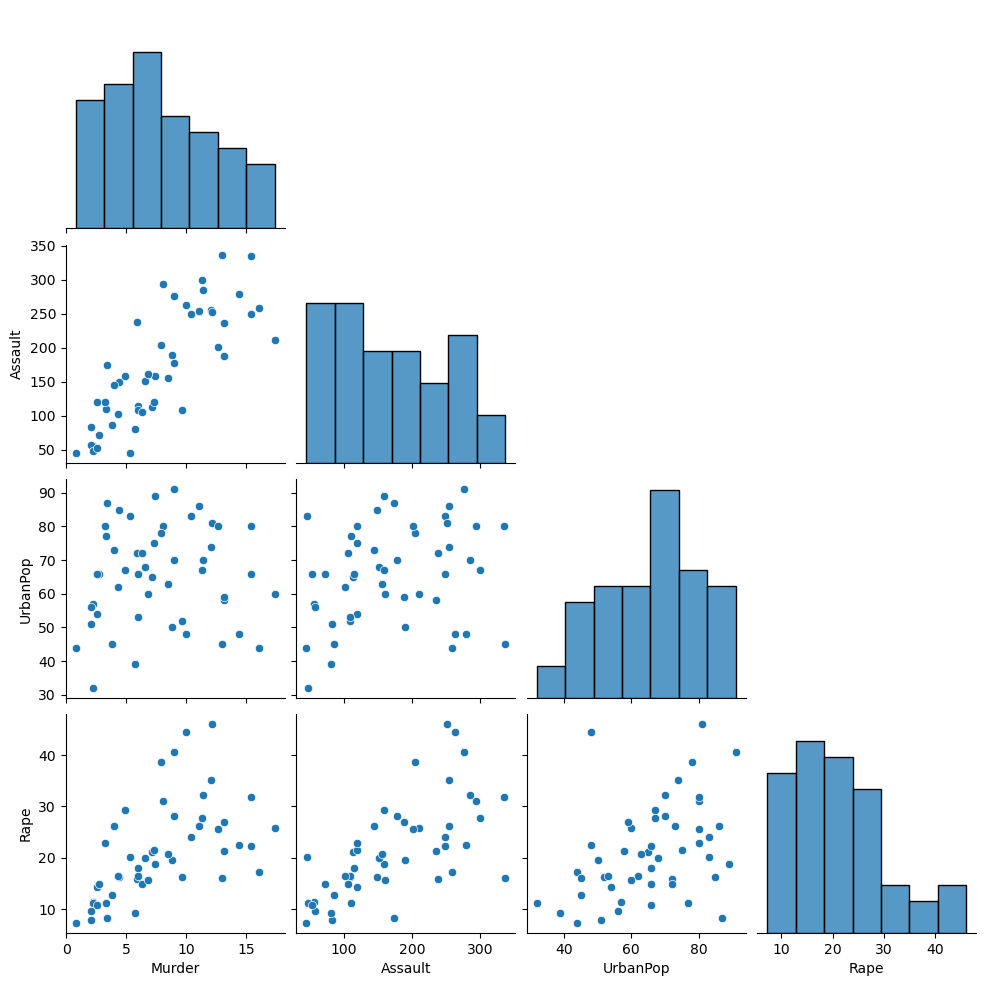

In [5]:
# Initial data inspection - pairplot(cornerplot)
sns.pairplot(arrests_df, corner=True)

## Correlation analysis

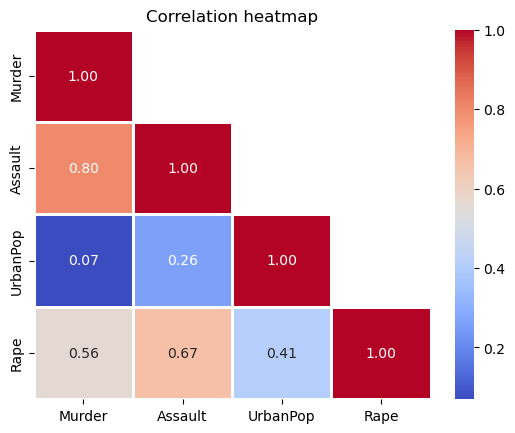

In [6]:
# Correlation heatmap
def corr_heatmap(df):
    """Produces a correlation heatmap of the features in a pandas.DataFrame
    
    Arguments:
        df (pandas.DataFrame): data for correlation visualisation
    """
    corrs = df.corr()
    
    # to mask mirrored side of heatmap
    dropSelf = np.zeros_like(corrs)
    # k=1 keeps the diagonal (to show 100% correlation of a feature with itself)
    dropSelf[np.triu_indices_from(dropSelf, k=1)] = True
    
    # Generate heatmap, with annotations of the correlation strength and 2-decimal floats
    ax = sns.heatmap(corrs, cmap="coolwarm", annot=True, fmt=".2f", mask=dropSelf, linewidth=2)
    ax.set_title("Correlation heatmap")


corr_heatmap(arrests_df)

As seen in the above correlation heatmap, there is a strong positive correlation (coefficient: 0.8) between Assault arrests and Murder arrests, and a similar (but slightly weaker) correlation (coefficient: 0.67) between Assault arrests and Rape arrests. These results are fairly intuitive - i.e. states with a high rate of arrests for one violent crime are likely to have a high rate of arrests for other violent crimes as well.

Interestingly, there seems to be a (relatively weak) positive correlation between both Assault (coefficient: 0.26) and Rape arrests (coefficient: 0.41) and the percentage of the population living in urban areas, whilst there appears to be almost no correlation between Murder arrests and percentage urban population (coefficient: 0.07).

## Preprocessing data - scaling

In [7]:
X = arrests_df.values

# Scaling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

## PCA

In [8]:
# Principal Component Analysis
pca = PCA()
X_pc = pca.fit_transform(X)

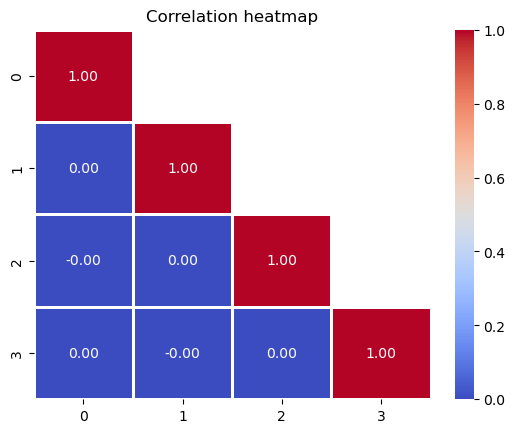

In [9]:
# Principal components correlation heatmap
pc_df = pd.DataFrame(X_pc, index=arrests_df.index)
corr_heatmap(pc_df)

We can see from the correlation heatmap of the principal components that there is no correlation between them. This is the expected result and is an inherent feature of PCA.

0      0.000000
1     64.272873
2     87.077478
3     95.175373
4    100.000000
dtype: float64


Text(0.5, 1.0, 'Cumulative explained variance')

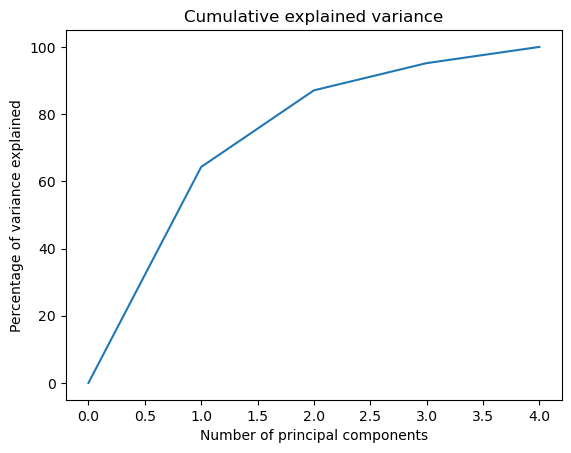

In [10]:
# Cumulative percentage of variance explained at each increase in number of components
x = range(len(pca.explained_variance_ratio_) + 1)
y = 100 * np.cumsum(np.concatenate((np.array([0]), pca.explained_variance_ratio_)))

variance_explained = pd.Series(y, index=x)
print(variance_explained)

# Plot
ax = variance_explained.plot()
ax.set_xlabel("Number of principal components")
ax.set_ylabel("Percentage of variance explained")
ax.set_title("Cumulative explained variance")

We can see from the plot above, that approximately 90% of the variance in the the data is explained by the first two principal components. These are the dimensions in which the data exhibits the most variance. After the second principal component, there is an 'elbow', which shows the relatively small contributions to the variance in the data made by the final two components.

See below for a visualisation of the relationships between these principal components and the original features in the dataset (arrests per 100,000 population and percentage urban population).

## Interpreting the principal components

<AxesSubplot: >

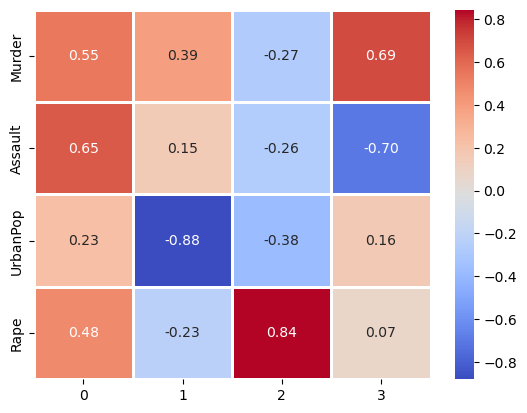

In [11]:
# Visualise relationships between principal components and original features
components = pd.DataFrame(
    pca.components_,
    columns=arrests_df.columns,
    index=range(len(pca.components_))
).transpose()

sns.heatmap(components, cmap="coolwarm", annot=True, fmt=".2f", linewidth=2)

We can see from the visualisation above, that the first principal component (0) correlates well with the number of arrests per 100,000 population for each of the violent crimes in the dataset. This component can be used as a one-dimensional representation of violent crime rate. A record with a large positive coefficient in dimension 0 after PCA has a high violent crime rate.

The second principal component (1) correlates very well with the percentage urban population. The correlation is stongly negative, so a record with a large negative coefficient in dimension 1 after PCA has a high urban population.

## Cluster identification 

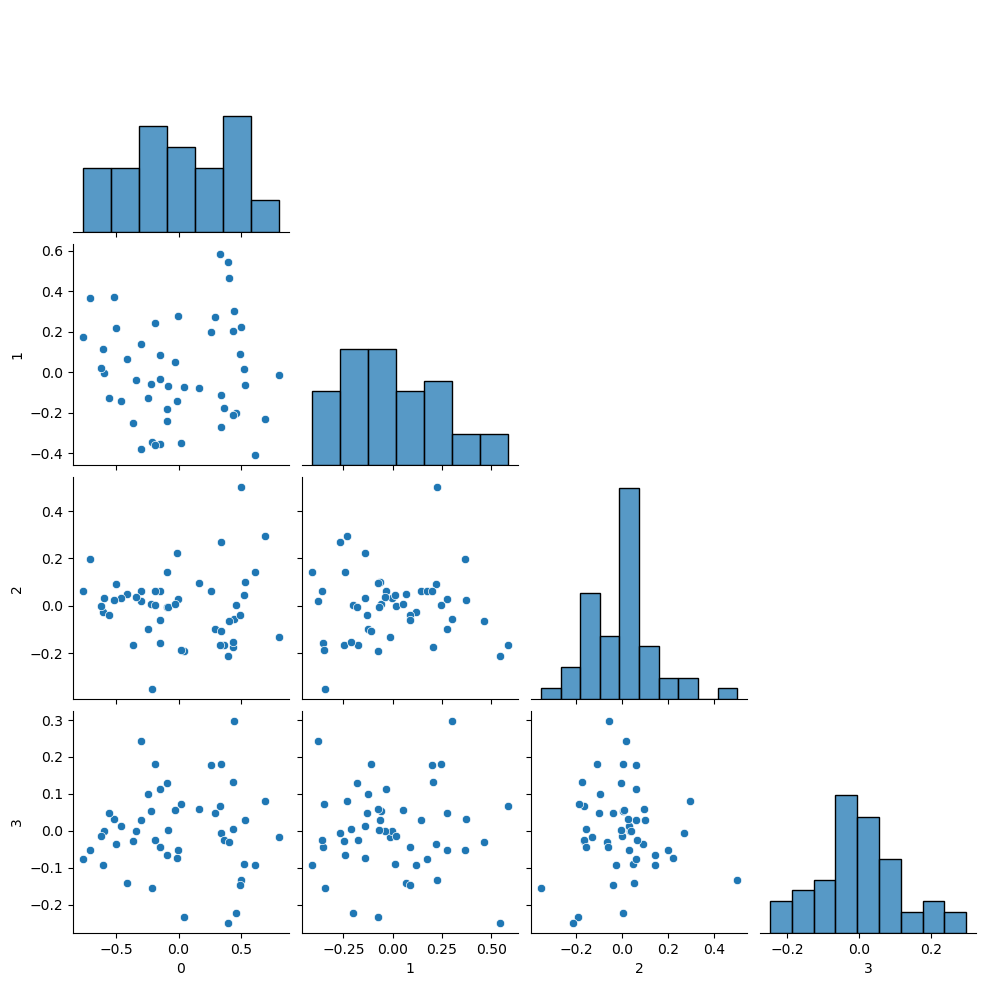

In [12]:
# Inspection of the pairplots of the principal components can indicate whether
# PCA will aid with identification of clusters
sns.pairplot(pd.DataFrame(X_pc), corner=True)

From the above pairplots after PCA, we can see two fairly well defined clusters in each of the scatter plots of PC0 against one of the other dimensions. These clusters represent more dangerous (positive PC0 coefficients) and safer (negative PC0 coefficients) respectively.

Based on this finding, it seems likely that a k-value of 2 will be appropriate for use in clustering.

### Agglomerative hierarchical clustering

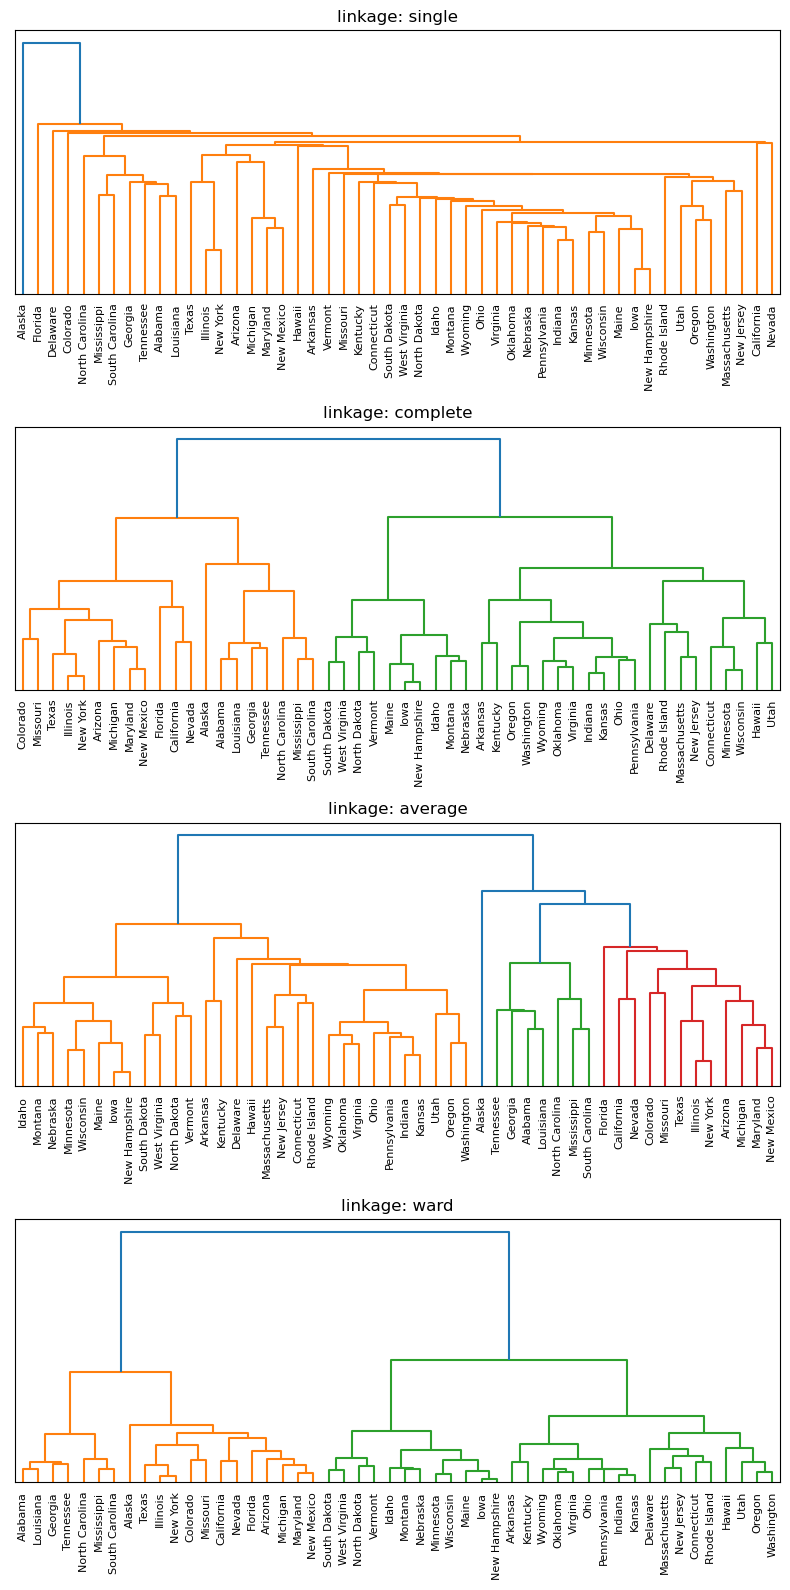

In [13]:
# Agglomerative clustering dendrograms - choosing clustering method
def dendrogram_plots(X, methods):
    """Plot agglomerative clustering dendrograms
    
    Arguments:
        X (np.array): clustering data
        methods (list): list of linkage methods to use e.g. ["single", "complete"]
    """
    fig, ax = plt.subplots(len(methods), 1, figsize=(8, 4*len(methods)))
    
    for i, link_method in enumerate(methods):
        if len(methods) == 1:
            axes = ax
        else:
            axes = ax[i]
        axes.set_title(f"linkage: {link_method}")
        axes.set_yticks([], [])

        dendrogram(
            linkage(X, method=link_method, metric="euclidean"),
            labels=arrests_df.index,
            ax=axes
        )
    
    plt.tight_layout()
    plt.show()


# Dendrograms for agglomerative clustering on principal components 
dendrogram_plots(X_pc, ["single", "complete", "average", "ward"])

Based on the above dendrograms and the earlier observation of the post-PCA pairplot, the complete linkage method seems to best represent the data - it clusters the data into two clusters (safer and more dangerous states), each accounting for approximately the expected proportion of the data - as per the visible clusters in the scatterplots above.

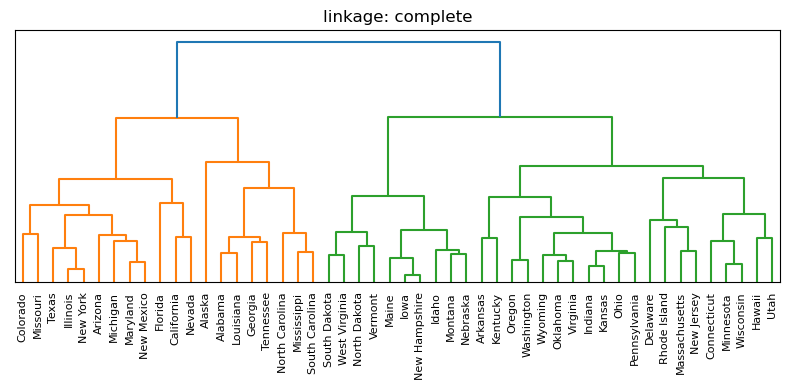

In [14]:
# Agglomerative clustering dendrogram - chosen method
dendrogram_plots(X, ["complete"])

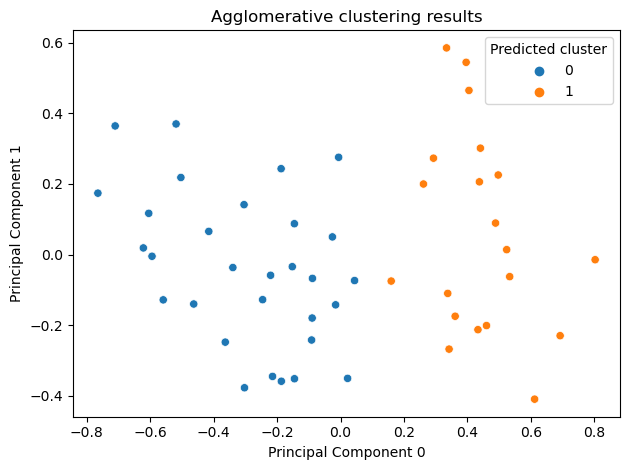

In [15]:
# Complete linkage, euclidean distance cluster visualisation
ax = plt.subplot(111)
ax.set_title("Agglomerative clustering results")

# set axis labels
ax.set_xlabel("Principal Component 0")
ax.set_ylabel("Principal Component 1")

# Run agglomerative clustering with selected parameters
cluster = AgglomerativeClustering(n_clusters=2, affinity="euclidean", linkage="complete")
y_pred = cluster.fit_predict(X_pc)

# Plot clusters for single linkage, euclidean/cityblock distance metrics
sns.scatterplot(
    ax=ax,
    x=X_pc[:, 0],
    y=X_pc[:, 1],
    hue=pd.Series(cluster.labels_).astype("category"),
)

ax.legend(title="Predicted cluster")

plt.tight_layout()

In [16]:
# Mapping clusters based on state names
# source: https://www.census.gov/geographies/mapping-files/time-series/geo/cartographic-boundary.html
state_geom = gpd.read_file("data/cb_2021_us_state_20m/cb_2021_us_state_20m.shp")

# Drop unneeded data
drop_cols = list(state_geom.columns[0:5]) + list(state_geom.columns[6:9])
state_geom.drop(drop_cols, axis=1, inplace=True)

# Only want entries for which we have data
state_geom = state_geom[state_geom["NAME"].isin(arrests_df.index)]

Text(0.5, 1.0, 'Clusters identified (agglomerative hierarchical clustering)')

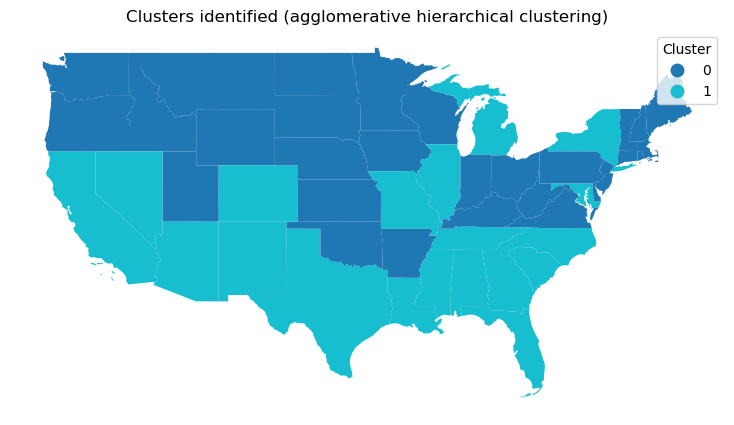

In [17]:
# Plot clusters identified with agglomerative clustering
clusters = pd.Series(y_pred, index=arrests_df.index, name="CLUSTER_AGGLOM")
state_geom = pd.merge(state_geom, clusters, left_on="NAME", right_index=True)

# Plot
# Don't want to plot Alaska or Hawaii
ax = state_geom[~state_geom["NAME"].isin(["Alaska", "Hawaii"])].plot(
    figsize=(10, 5),
    linewidth=2,
    column="CLUSTER_AGGLOM",
    categorical=True,
    legend=True,
    legend_kwds={
        "title": "Cluster"
    }
)

ax.set_axis_off()
ax.set_title("Clusters identified (agglomerative hierarchical clustering)")

Based on the map above, we can see that the safer states (cluster 0) seem to generally be located in the north of the US mainland, whereas the more dangerous states tend to be located in the south.

### KMeans clustering

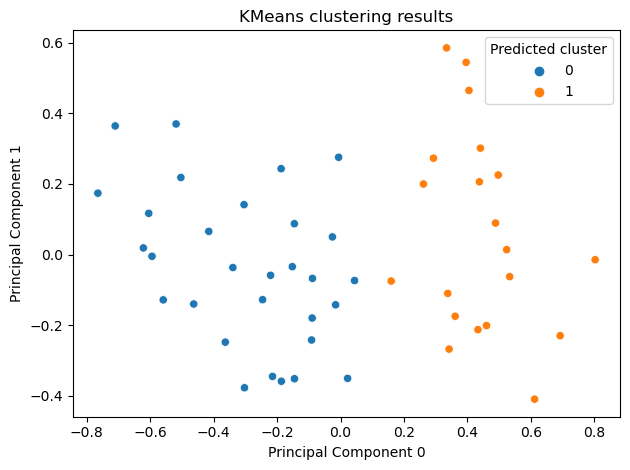

In [18]:
# KMeans clustering
ax = plt.subplot(111)
ax.set_title("KMeans clustering results")

# set axis labels
ax.set_xlabel("Principal Component 0")
ax.set_ylabel("Principal Component 1")

# Run agglomerative clustering with selected parameters
cluster = KMeans(n_clusters=2)
y_pred = cluster.fit_predict(X_pc)

# Plot clusters for single linkage, euclidean/cityblock distance metrics
sns.scatterplot(
    ax=ax,
    x=X_pc[:, 0],
    y=X_pc[:, 1],
    hue=pd.Series(cluster.labels_).astype("category"),
)

ax.legend(title="Predicted cluster")

plt.tight_layout()

Text(0.5, 1.0, 'Clusters identified (KMeans clustering)')

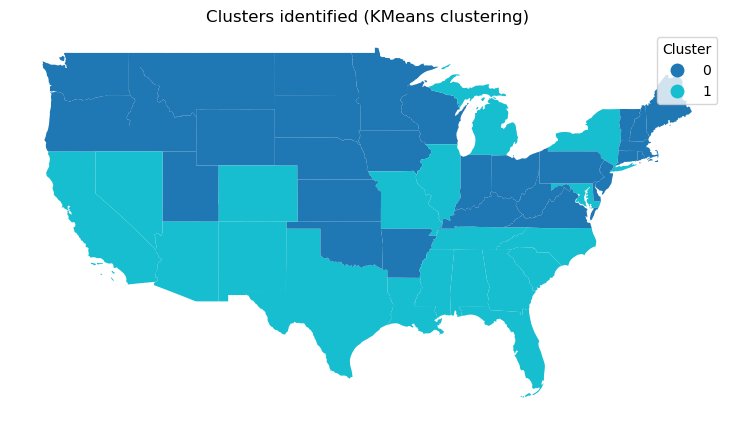

In [19]:
# Plot clusters identified with KMeans clustering
clusters = pd.Series(y_pred, index=arrests_df.index, name="CLUSTER_KMEANS")
state_geom = pd.merge(state_geom, clusters, left_on="NAME", right_index=True)

# Plot
# Don't want to plot Alaska or Hawaii
ax = state_geom[~state_geom["NAME"].isin(["Alaska", "Hawaii"])].plot(
    figsize=(10, 5),
    linewidth=2,
    column="CLUSTER_KMEANS",
    categorical=True,
    legend=True,
    legend_kwds={
        "title": "Cluster"
    }
)

ax.set_axis_off()
ax.set_title("Clusters identified (KMeans clustering)")

KMeans appears to give the same results as agglomerative clustering, identifying a group of more dangerous states (labelled cluster 0 in the KMeans model), predominantly located in the south of the US mainland, and a safer group of states, predominantly located in the north.